In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from scipy.io import loadmat
from scipy.io import savemat
import h5py
sys.path.append('/home/jamalzada/.conda/envs/anal/lib/python3.6/site-packages')
import sigpy as sp
import sigpy.mri as mr
import sigpy.plot  as pl
import numpy.testing as npt
from bart import bart
import matlab.engine as me
import glob
import matlab
from joblib import Parallel, delayed

In [4]:
eng = me.start_matlab()

In [2]:
def caipi(r,ry,shifts):
    """Generates Caipirinha binary unit cells on sheared grids that form periodic lattices
    
    Parameters:
        r (int): total acceleration factor
        ry (int): acceleration factor in the y-direction
        shifts (list), (numpy array): size of shifts in the z-direction
    
    Returns:
        3D numpy array [shifts, ry, rz] containing the patterns
        
    
    """
    rz = int(r/ry)
    patterns = np.zeros((len(shifts),r,r))
    l = 0
    for i, shift in enumerate(shifts):
        cell = np.zeros((r,r))
        for row in range(rz):
            if (shift*row+rz)>= r:
                l = (shift*row%r+rz)%rz
            else:
                l = shift*row
            cell[row*ry,l::rz]=1
        patterns[i] = np.copy(cell)
    return patterns

In [3]:
def read_matlab(filename):
    """Load .mat file
    """
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

In [4]:
def plot_patterns(matrix,rows=8, cmap='gray'):
    n_patterns = len(matrix)
    R = matrix.shape[1]
    k = int(n_patterns/rows)+((n_patterns%rows)>0)
    s = np.arange(n_patterns)+1
    plt.figure(figsize=(12,10))
    for i in np.arange(n_patterns):
        plt.subplot(k,rows,s[i])
        plt.imshow(matrix[i],cmap=cmap)
        plt.title('$\Delta=$ {}'.format(i))
        ax = plt.gca();

        # Major ticks
        ax.set_xticks([]);
        ax.set_yticks([]);

        # Labels for major ticks
        ax.set_xticklabels([]);
        ax.set_yticklabels([]);

        # Minor ticks
        ax.set_xticks([], minor=True);
        ax.set_yticks([], minor=True);

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)


In [5]:
def plot_caipi(matrix, shifts,rows=8):
    n_patterns = len(matrix)
    R = matrix.shape[1]
    k = int(n_patterns/rows)+((n_patterns%rows)>0)
    s = np.array(shifts)+1
    plt.figure(figsize=(16,8))
    for i in np.arange(n_patterns):
        plt.subplot(k,rows,s[i])
        plt.imshow(matrix[i])
        plt.title('$\Delta=$ {}'.format(shifts[i]))
        ax = plt.gca();

        # Major ticks
        ax.set_xticks(np.arange(0, R, 1));
        ax.set_yticks(np.arange(0, R, 1));

        # Labels for major ticks
        ax.set_xticklabels(np.arange(1, R+1, 1));
        ax.set_yticklabels(np.arange(1, R+1, 1));

        # Minor ticks
        ax.set_xticks(np.arange(-.5, R, 1), minor=True);
        ax.set_yticks(np.arange(-.5, R, 1), minor=True);

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
def swap(array,ind = 0):
    if array.ndim==3:
        if ind == 0:
            nc, x, y = array.shape
            h_array = np.zeros((x,y,nc),dtype=complex)
            for i in range(nc):
                h_array[:,:,i] = np.copy(array[i])
        else:
            x, y, nc = array.shape
            h_array = np.zeros((nc,x,y),dtype=complex)
            for i in range(nc):
                h_array[i] = np.copy(array[:,:,i])
    elif array.ndim==4:
        if ind == 0:
            nc, x, y, z = array.shape
            h_array = np.zeros((x,y,z,nc),dtype=complex)
            for i in range(nc):
                h_array[:,:,:,i] = np.copy(array[i])
        else:
            x, y, z, nc = array.shape
            h_array = np.zeros((nc,x,y,z),dtype=complex)
            for i in range(nc):
                h_array[i] = np.copy(array[:,:,:,i])
    return h_array


In [6]:
path = '/home/jamalzada/Downloads/raw_data.mat'
data = read_matlab(path)
ksp = data['raw'].squeeze()
sdata = loadmat('sref.mat')
g=sdata['s_ref']

In [10]:
data_complex[0].ndim

NameError: name 'data_complex' is not defined

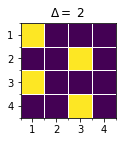

In [99]:
p=caipi(4,1,[2])
plot_caipi(p,[2])
mask = np.kron(np.ones((24,24)),p[0])

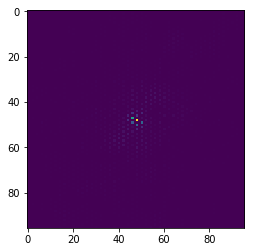

In [102]:
plt.imshow(abs(kspm*mask[:,:,None,None])[:,:,0,0])

In [101]:
raw = ksp['real']+1j*ksp['imag']
kspm = swap(raw)
kspm = kspm[:,:,None,:]*mask[:,:,None,None]
kspm.shape
savemat('raw_datam.mat',{'raw':kspm})


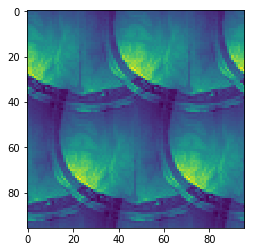

In [107]:
target_data = sp.ifft(kspm,axes=[0,1])
plt.imshow(abs(target_data)[:,:,0,0])
target_datam = matlab.double(target_data.tolist(),size=[96,96,1,16],is_complex=True)
sensem = matlab.double(g.tolist(),is_complex=True)
acc_factors = matlab.double([1,4,1])
caipi_shifts = matlab.double([2,2])

In [108]:

results = eng.SENSE_unfold_CAIPI(target_datam,sensem,acc_factors,caipi_shifts)

In [109]:
npresults=np.asarray(results)

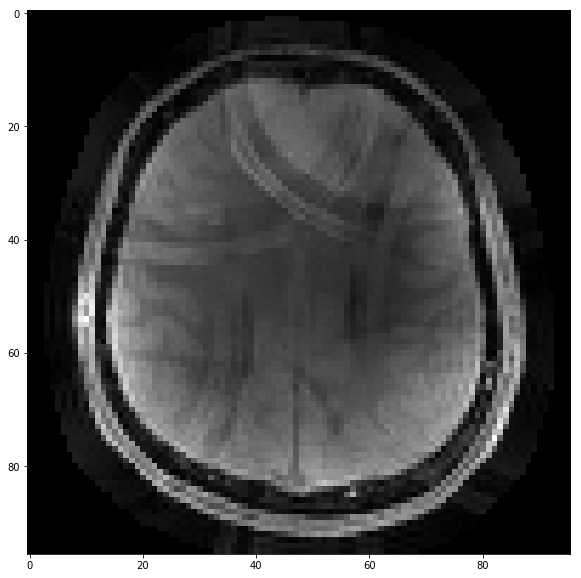

In [110]:
plt.figure(figsize=(20,10))
plt.imshow(abs(npresults),'gray')

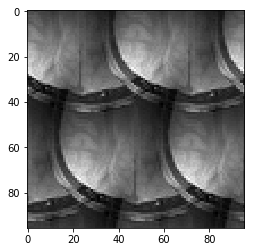

In [111]:
plt.imshow(abs(np.fft.fftshift(np.fft.ifftn(kspm,axes=(0,1)),axes=(0,1)))[:,:,0,0],'gray')

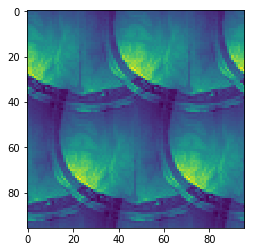

In [112]:
plt.imshow(abs(sp.ifft(kspm,axes=[0,1]))[:,:,0,0])

In [113]:
raw = ksp['real']+1j*ksp['imag']
kspm = swap(raw)
kspm = kspm[:,:,None,:]*mask[:,:,None,None]
kspm.shape
kspm = sp.ifft(kspm,axes=(0,1))
savemat('raw_datam.mat',{'raw':kspm})

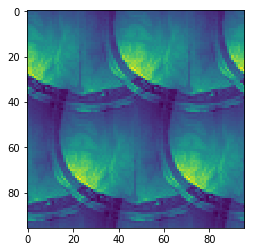

In [114]:
plt.imshow(abs(kspm[:,:,0,0]))

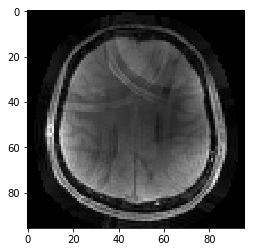

In [115]:
crecon = loadmat('caipi_recon.mat')['recon']
plt.imshow(abs(crecon),'gray')


In [116]:
s = np.asarray([g[:,:,0,i] for i in range(16)])

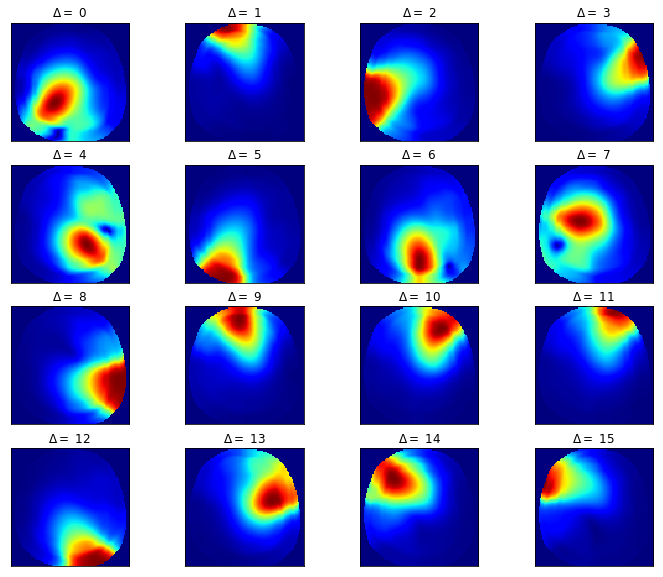

In [117]:
plot_patterns(abs(s),4,cmap='jet')

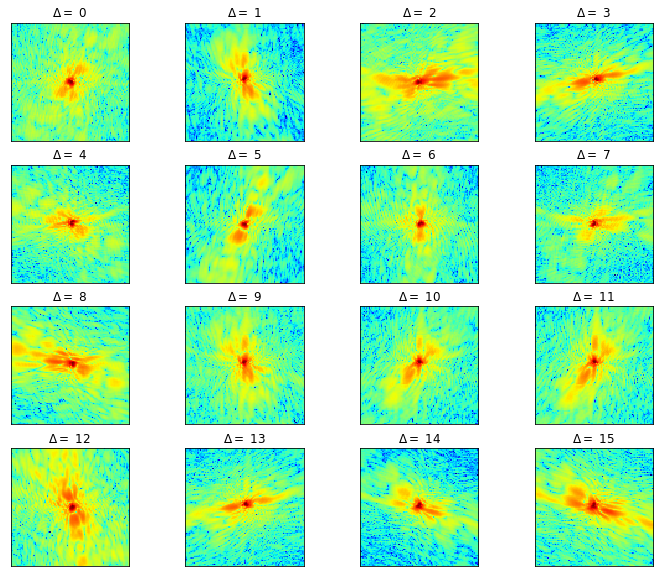

In [118]:
raw = ksp['real']+1j*ksp['imag']
plot_patterns(np.log(abs(raw)),4,'jet')

In [119]:
imgnp = np.fft.fftshift(np.fft.ifftn(raw,axes=(1,2)),axes=(1,2))

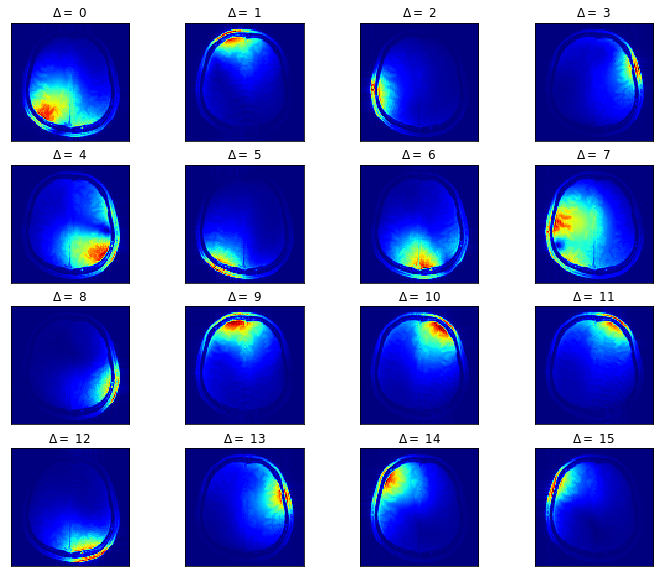

In [120]:
img=sp.ifft(raw,axes=[-1,-2])
plot_patterns(abs(img),4,'jet')

(96, 96)


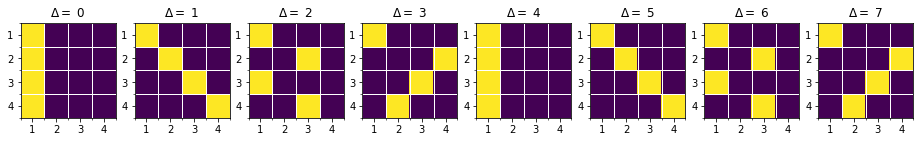

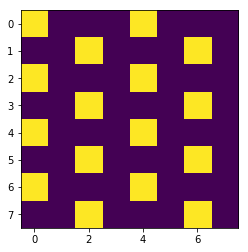

In [144]:
shifts = [0,1,2,3,4,5,6,7]
R=4
mask = caipi(R,1,shifts)
plot_caipi(mask,shifts)
mask = np.kron(np.ones((int(96/R),int(96/R))),mask[2])
plt.figure()
plt.imshow(mask[:8,:8])
print(mask.shape)

In [122]:
#mask=np.zeros((96,96))
#mask[::2,:]=1

imgc=sp.ifft(mask[None,:,:]*raw,axes=[1,2])

In [123]:
rawtest = np.asarray([raw[i]*mask for i in range(16)])

In [124]:
imgc=sp.ifft(rawtest,axes=[1,2])

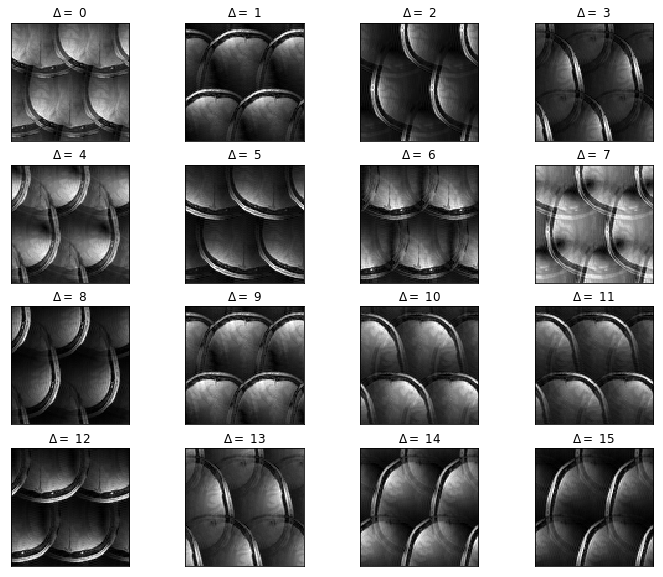

In [147]:
plot_patterns(abs(imgc),4,cmap='gray')

In [148]:
img_rec = sp.mri.app.SenseRecon(mask*raw,s,lamda=0, solver = 'ConjugateGradient',show_pbar=True).run()

Text(0.5,1,'Caipi sampling CAIPI Recon')

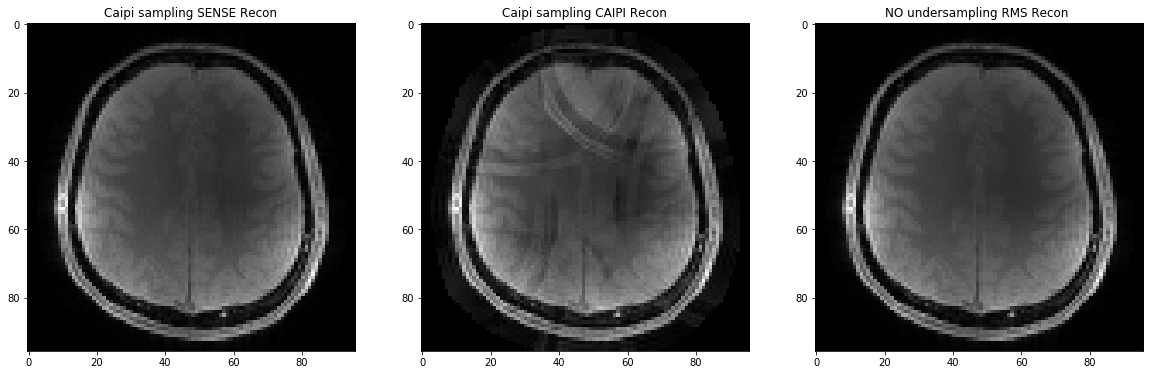

In [149]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(abs(img_rec),'gray')
plt.title('Caipi sampling SENSE Recon')
plt.subplot(1,3,3)
plt.imshow(abs(img_comb),'gray')
plt.title('NO undersampling RMS Recon ')
plt.subplot(1,3,2)
plt.imshow(abs(npresults),'gray')
plt.title('Caipi sampling CAIPI Recon')

In [ ]:
#npt.assert_allclose(img_rec,img_comb,atol=1e-2,rtol=1e-2,verbose=False)

In [ ]:
x = []
y = []


In [128]:
raw_bart=np.zeros((96,96,16),dtype=complex)
for i in range(16):
    raw_bart[:,:,i]=raw[i]
s_raw = np.zeros((96,96,16),dtype=complex)
for i in range(16):
    s_raw[:,:,i]=s[i]

In [139]:
img_comb = np.nan_to_num(np.sum(img*np.conj(s),axis=0)/np.sum(abs(s)**2,axis=0))

/packages/development/anaconda/3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


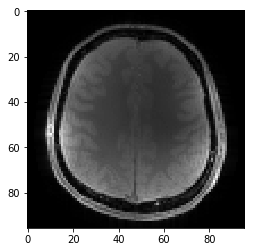

In [141]:
plt.imshow(abs(img_comb),cmap='gray')

In [132]:
Nx=96
Ny=96
Nc=16
c = np.zeros((Nx*Ny*Nc,Nx*Ny),dtype=complex)

In [ ]:
c = np.zeros((Nx*Ny,Nx*Ny),dtype=complex)

In [ ]:
for i in range(Nc):
    c = np.vstack((c,np.diag(s[i].flatten())))

In [ ]:
c.shape

In [ ]:
s[i].shape

In [ ]:
a = np.array([[[1,1],[1,1]],[[2,2],[2,2]]])

In [ ]:
np.vstack(a)

In [ ]:
S = [np.diag(s[i].flatten()) for i in range(16)]

In [ ]:
test = np.asarray(S)

In [ ]:
cstack = np.vstack(test)

In [ ]:
cstack.shape

In [ ]:
s.shape

In [ ]:
A = sp.mri.linop.Sense(s)

In [ ]:
def check_linop_adjoint(A, dtype=np.float, device=sp.cpu_device):

    device = sp.Device(device)
    x = sp.randn(A.ishape, dtype=dtype, device=device)
    y = sp.randn(A.oshape, dtype=dtype, device=device)

    xp = device.xp
    with device:
        lhs = xp.vdot(A * x, y)
        rhs = xp.vdot(x, A.H * y)

        xp.testing.assert_allclose(lhs, rhs, atol=1e-5, rtol=1e-5)

In [ ]:
img_shape = [16, 16]
mps_shape = [8, 16, 16]

imgs = sp.randn(img_shape, dtype=np.complex)
mps = sp.randn(mps_shape, dtype=np.complex)

mask = np.zeros(img_shape)
mask[::2, ::2] = 1.0

B = sp.mri.linop.Sense(mps)

check_linop_adjoint(A, dtype=np.complex)

npt.assert_allclose(sp.fft(imgs * mps, axes=[1, 2]),
                    B * imgs)

In [ ]:
sp.fft(imgs*mps,axes=[-1,-2]).shape

In [ ]:
(A*img).shape

In [ ]:
g=sp.ifft(img*s,axes=[-1,-2])

In [ ]:
plot_patterns(np.log(abs(g)),4,'jet')

In [ ]:
plot_patterns(np.log(abs(A*img_comb)),4,'jet')

In [ ]:
mps = sp.mri.sim.birdcage_maps([16,96,96])
shep = sp.shepp_logan([96,96])

In [ ]:
plot_patterns(abs(mps),4,'jet')

In [ ]:
plot_patterns(abs(shep*mps),4,'jet')

In [9]:
def shepp_logan_setup():
    img_shape = [6, 6]
    mps_shape = [4, 6, 6]

    img = sp.shepp_logan(img_shape)
    mps = sp.mri.sim.birdcage_maps(mps_shape)

    mask = np.zeros(img_shape)
    mask[:, ::2] = 1

    ksp = mask * sp.fft(mps * img, axes=[-2, -1])
    return img, mps, ksp

In [10]:
i,m,k=shepp_logan_setup()

In [ ]:
mask = np.zeros((96,96))
mask[:,::4]=1

In [ ]:
plt.imshow(mask[:8,:8])

In [ ]:
raw.shape

In [ ]:
img_rec = sp.mri.app.SenseRecon(mask*raw,s,lamda=0, solver = 'ConjugateGradient',show_pbar=True).run()

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(abs(img_rec),'gray')
plt.title('Caipi sampling SENSE Recon')
plt.subplot(1,2,2)
plt.imshow(abs(img_comb),'gray')
plt.title('RMS Recon NO undersampling')

In [ ]:
shifts = [0,1,2,3]
p=caipi(4,1,shifts)

In [ ]:
plot_caipi(p,shifts)

In [7]:
path_caipi_data = '/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/'

In [8]:
datalist = sorted(glob.glob(path_caipi_data+"raw*.mat"))
datalist

['/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/raw_001_full.mat',
 '/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/raw_002_sense2x2.mat',
 '/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/raw_003_sense2x3.mat',
 '/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/raw_004_caipi2x2.mat',
 '/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/raw_005_caipi2x3.mat',
 '/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/raw_006_caipi2x2_fullcenter.mat',
 '/home/jamalzada/bart-workshop/demos/gfactor-demo/200403_caipi_pilot/raw_007_caipi2x3_fullcenter.mat']

In [13]:
data_help = Parallel(n_jobs=-1)(delayed(read_matlab)(datalist[i]) for i in range(len(datalist)))

In [14]:
data_complex = [data_help[i]['alldata']['real']+1j*data_help[i]['alldata']['imag'] for i in range(len(datalist))]

In [15]:
ksp = np.load('cartesian_ksp.npy')
ksp.shape

(8, 230, 180)

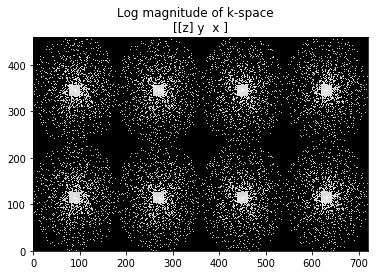

In [16]:
pl.ImagePlot(ksp, mode='l',z=0, title='Log magnitude of k-space')

In [ ]:
g=sp.ifft(data_complex[0],axes=(1,2,3))

In [ ]:
gg = np.fft.ifftn(data_complex[0],axes=(1,2,3))

In [18]:
plt.imshow(abs(gg)[31,:,0,:])

NameError: name 'gg' is not defined

In [17]:
mask = np.zeros(ksp.shape[1:])
mask[::2,::]=1

In [18]:
mask.shape

(230, 180)

In [46]:
espirit = mr.app.EspiritCalib(ksp*mask[None,:,:],show_pbar=True).run()

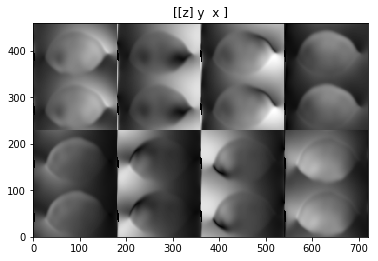

In [47]:
pl.ImagePlot(espirit,z=0)

In [48]:
img_rec = sp.mri.app.SenseRecon(ksp*mask[None,:,:],espirit,lamda=0.01,solver = 'ConjugateGradient',show_pbar=True).run()

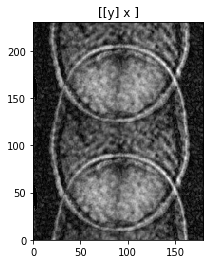

In [49]:
pl.ImagePlot(img_rec)

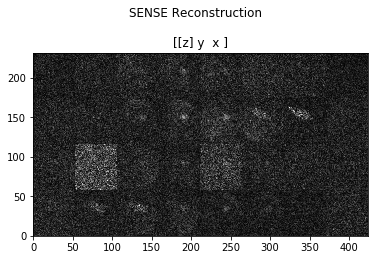

In [22]:
pl.ImagePlot(np.fft.ifftn(data_complex[1][:,:,0,:],axes=(1,2)), z=0,title='SENSE Reconstruction')

In [23]:
imgk = data_complex[0][:,:,:,:]
img = np.fft.ifftn(imgk,axes=(1,2,3))

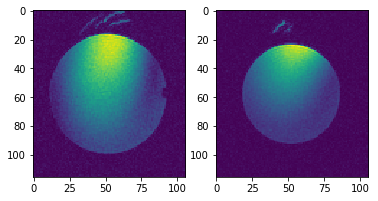

In [24]:
plt.subplot(1,2,1)
plt.imshow(abs(img)[0,:,100,:])
plt.subplot(1,2,2)
plt.imshow(abs(img[0,:,10,:]))

In [39]:
imgk2 = data_complex[0][:,:,100,:]
img2 = np.fft.ifftn(imgk2,axes=(1,2))

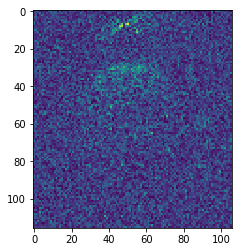

In [40]:
plt.imshow(abs(img2[0]))

In [44]:
de = np.array([[[1,2],[3,4]],[[5,6],[7,8]]])

In [46]:
#DFT in 3d is not same as 2d
np.fft.ifftn(de,axes=(0,1,2))

array([[[ 4.5+0.j, -0.5+0.j],
        [-1. +0.j,  0. +0.j]],

       [[-2. +0.j,  0. +0.j],
        [ 0. +0.j,  0. +0.j]]])

In [59]:
np.fft.ifftn(de[0,:,:])

array([[ 2.5+0.j, -0.5+0.j],
       [-1. +0.j,  0. +0.j]])

In [60]:
(1+2+3+4)/4

2.5

In [67]:
mps=sp.mri.birdcage_maps((8,96,96,96))

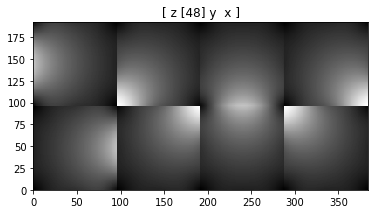

In [68]:
pl.ImagePlot(mps,z=0)

In [18]:
kps_shepp = sp.shepp_logan((50,96,50))

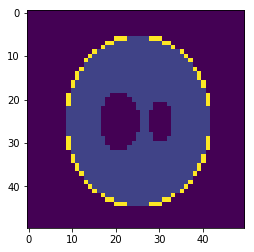

In [19]:
plt.imshow(abs(kps_shepp[:,40,:]))

In [92]:
imgc = np.fft.fftn(kps_shepp)

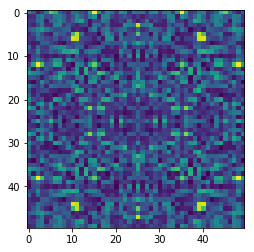

In [96]:
plt.imshow(abs(imgc[:,40,:]))

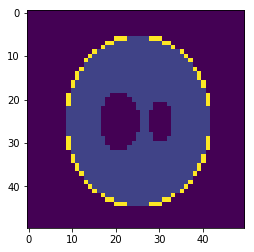

In [97]:
plt.imshow(abs(np.fft.ifftn(imgc)[:,40,:]))

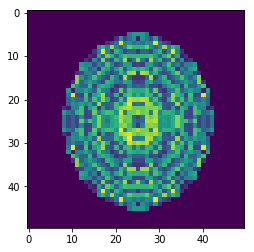

In [101]:
plt.imshow(abs(np.fft.ifftn(imgc[:,40,:])))

In [27]:
test_mat = swap(data_complex[0])
g=test_mat.tolist()
target_data = matlab.double(g,size=test_mat.shape,is_complex=True)

In [201]:
target_data = loadmat('full_mat_for_adapt_est_sens.mat')

In [204]:
gg=target_data['raw']

In [206]:
gg.shape

(116, 108, 106, 32)

In [23]:
b=np.random.random((10,10))

In [3]:
b.shape

(10, 10)